In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [3]:
def get_area_weights(lat, lon, latname='latitude', lonname='longitude'):
    '''
    Get the area weights based on a lat/lon grid

    Inputs
    ------
    lat : xr.DataArray
        Latitude array
    
    Returns
    -------
    xr.DataArray
        Area weights
    '''

    lat_rad = np.radians(lat).values  # Convert latitude to radians
    weights = (np.cos(lat_rad))[np.newaxis, :] # Compute weights as cos(latitude)
    # llat, llon = np.meshgrid(lat, lon) # Create meshgrid
    weights_mesh = np.tile(weights, (len(lon), 1)).T # Tile weights to match meshgrid
    
    return xr.DataArray(weights_mesh, coords=[lat, lon], dims=[latname, lonname])


In [4]:
def euclidean_distance(field,event):
    '''
    Calculate the euclidean distance between a field and an event.

    Inputs
    -------
      field = single cube of psi.
      event = cube of single day of event to match.
      BOTH MUST HAVE SAME DIMENSIONS FOR LAT/LON

    Outputs
    -------
        D = list of euclidean distances between field and event.
    
    Written by Vikki Thompson and Shirin Ermis.
    '''
    D = []  # to be list of all euclidean distances
    
    # if not event.coord('latitude').has_bounds():
    #     event.coord('latitude').guess_bounds()
    # if not event.coord('longitude').has_bounds():
    #     event.coord('longitude').guess_bounds()
    
    weights = get_area_weights(event.latitude, event.longitude)
    event = event * weights
    members, lats, lons = np.shape(field.data) # get dimensions of field
    field = field * np.array([weights] * members) 
    
    XA = event.data.reshape(lats * lons, 1)
    XB = field.data.reshape(members,lats * lons, 1)
    
    for Xb in XB:
        D.append(np.sqrt(np.sum(np.square(XA - Xb))))
    
    return D

In [5]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'))
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-23 00'))

In [6]:
# Define area, same as for analogues
lat_min = 40
lat_max = 65
lon_min = -20
lon_max = 20

# For forecast-based runs

In [7]:
# Import forecast data 
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [97]:
# test =exp['pi'].sel(time=slice('2023-10-20 00', '2023-10-21 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max), inidate='2023-10-17', number=1).mean(dim='time').msl
# get_area_weights(test.latitude, test.longitude).shape

In [98]:
era5_20 = era5.sel(time=slice('2023-10-20 00', '2023-10-21 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)).mean(dim='time').msl
exp20 = {exp_key: exp[exp_key].sel(time=slice('2023-10-20 00', '2023-10-21 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max), inidate=slice('2023-10-15', '2023-10-17')).mean(dim='time').msl for exp_key in exp.keys()}
distance = {}
inidates = ['2023-10-15', '2023-10-17']

for inidate in inidates:
    distance[inidate] = {}
    for experiment in experiments:
            ensemble = exp20[experiment].sel(inidate=inidate)
            distance[inidate][experiment] = euclidean_distance(ensemble, era5_20)

In [99]:
plot_data = []
    
for outer_key, inner_dict in distance.items():
    for inner_key, dask_array in inner_dict.items():
        values = dask.compute(*dask_array)  # Convert dask array to NumPy
        for v in values:
                plot_data.append({'inidate': outer_key, 'experiment': inner_key, 'euclidean_distance': v})
    
df = pd.DataFrame(plot_data)

In [11]:
colors = [color_palette[0], color_palette[4], color_palette[1]]

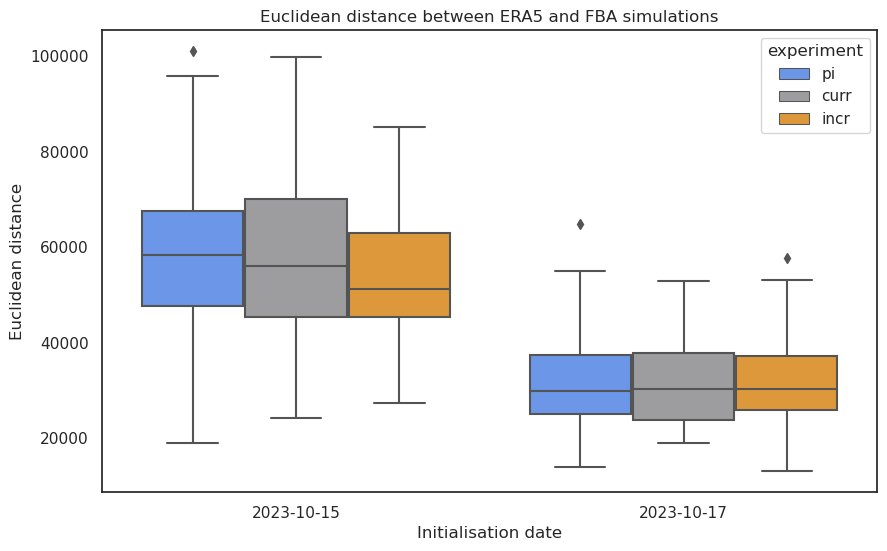

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='inidate', y='euclidean_distance', hue='experiment', data=df, palette=colors)
plt.ylabel('Euclidean distance')
plt.xlabel('Initialisation date')
plt.title("Euclidean distance between ERA5 and FBA simulations")
plt.legend(title='experiment')
plt.show()

# For all methods

In [9]:
def mean_euclidean_distance(field,event, latname='latitude', lonname='longitude'): # regridding to the field
    '''
    Calculate the euclidean distance between a field and an event.

    Inputs
    -------
      field = single cube of psi.
      event = cube of single day of event to match.
      latname = name of latitude coordinate in field
      lonname = name of longitude coordinate in field

    Outputs
    -------
        D = list of euclidean distances between field and event.
    
    Written by Vikki Thompson and Shirin Ermis.
    '''

    event = event.interp(latitude=field[latname], longitude=field[lonname], method='linear')

    weights = get_area_weights(event.latitude, event.longitude, latname=latname, lonname=lonname)
    event = event * weights
    members, lats, lons = np.shape(field.data) # get dimensions of field
    field = field * np.array([weights]  * members) 

    XA = event.data.reshape(lats * lons, 1)
    XB = field.data.reshape(members, lons * lats, 1)

    D = []  # to be list of all euclidean distances

    for Xb in XB:
        D.append(np.sqrt(np.nanmean(np.square(XA - Xb))))
    
    return D

In [10]:
def mean_euclidean_distance2(field,event, latname='latitude', lonname='longitude'): # regridding to era5
    '''
    Calculate the euclidean distance between a field and an event.

    Inputs
    -------
      field = single cube of psi.
      event = cube of single day of event to match.
      latname = name of latitude coordinate in field
      lonname = name of longitude coordinate in field

    Outputs
    -------
        D = list of euclidean distances between field and event.
    
    Written by Vikki Thompson and Shirin Ermis.
    '''

    field = field.interp({latname: event.latitude, lonname: event.longitude}, method='linear')
    
    weights = get_area_weights(event.latitude, event.longitude, latname='latitude', lonname='longitude')
    event = event * weights
    members, lats, lons = np.shape(field.data) # get dimensions of field
    field = field * np.array([weights]  * members) 

    XA = event.data.reshape(lats * lons, 1)
    XB = field.data.reshape(members, lons * lats, 1)

    D = []  # to be list of all euclidean distances

    for Xb in XB:
        D.append(np.sqrt(np.nanmean(np.square(XA - Xb))))
    
    return D

compare the MSL mean state to that of the ERA5. This is different to what we have for the analogue definition.

In [11]:
era5_72 = era5.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)).mean(dim='time').msl/100

In [12]:
# Data import

# ERA5 analogues
era5_analogues = bb.data.Data.get_era5_analogues()
era5_analogues['msl'] = era5_analogues['msl'].sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))/100

# RACMO analogues
racmo_msl, racmo_tp = bb.data.Data.get_racmo_indiv_analogues()
racmo_msl = racmo_msl.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))/100

# PGW 
pgw = bb.data.Data.get_pgw_ensemble()
pgw['msl'] = (pgw.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).mean('time').squeeze())/100

# FBA IFS
ifs = bb.data.Data.get_fba_ifs()
ifs['msl'] = ifs.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)).mean(dim='time')/100

# FBA MICAS -- not ready
micas = bb.data.Data.get_fba_micas()
micas['msl'] = micas.msl.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).mean(dim='time')/100


Importing data from pre-existing file
Importing data from pre-existing file
Importing data from pre-existing file
Importing data from pre-existing file


In [13]:
# ERA5 analogues
era5_analogues_dist = np.array(dask.compute(mean_euclidean_distance2(era5_analogues.sel(climate='1950').msl, era5_72, latname='lat', lonname='lon')))[0]

In [14]:
# RACMO analogues
racmo_analogues_dist = {}
for clim in ['1950', 'future1', 'future2']:
    with_members = racmo_msl.sel(climate=clim).msl
    racmo_analogues_dist[clim] = np.array(dask.compute(mean_euclidean_distance2(with_members, era5_72, latname='lat', lonname='lon')))[0]

In [15]:
# PGW
pgw_dist = {}
for clim in ['1870', 'future1', 'future2']:
    with_members = pgw.sel(climate=clim).msl
    pgw_dist[clim] = np.array(dask.compute(mean_euclidean_distance2(with_members, era5_72, latname='lat', lonname='lon')))[0]

In [16]:
# IFS
ifs_dist = {}
for ini in ['2023-10-15', '2023-10-17']:
    ifs_dist[ini] = {}
    for clim in ['1870', '1950', 'future1']:
        with_members = ifs.sel(climate=clim, inidate=ini).msl
        ifs_dist[ini][clim] = np.array(dask.compute(mean_euclidean_distance2(with_members, era5_72, latname='latitude', lonname='longitude')))[0]

In [17]:
# MICAS
micas_dist = {}
for clim in ['1870', 'future1']:
    with_members = micas.sel(climate=clim).msl
    micas_dist[clim] = np.array(dask.compute(mean_euclidean_distance2(with_members, era5_72, latname='lat', lonname='lon')))[0]

# Plot for all methods

In [18]:
methods = ['ERA5', 'RACMO', 'PGW', 'IFS', 'MICAS']
# ERA5
era5_df = pd.DataFrame(data=era5_analogues_dist, columns=['distance']).assign(climate="1950", method="ERA5 analogues")

# RACMO
racmo_df = pd.concat(
    [pd.DataFrame({"distance": arr}).assign(climate=key, method="RACMO analogues")
     for key, arr in racmo_analogues_dist.items()],
    ignore_index=True
)
# PGW
pgw_df = pd.concat(
    [pd.DataFrame({"distance": arr}).assign(climate=key, method="PGW")
     for key, arr in pgw_dist.items()],
    ignore_index=True
)
# IFS
# nested_dfs = [[pd.DataFrame({"distance": arr}).assign(climate=key_clim, inidate=inidate, method="FBA IFS")
#      for inidate, arr in inner_dict.items()] 
#      for key_clim, inner_dict in ifs_dist.items()]
# flat_dfs = [df for sublist in nested_dfs for df in sublist]
ifs15_df = pd.concat(
    [pd.DataFrame({"distance": arr}).assign(climate=key, method="FBA IFS 15")
     for key, arr in ifs_dist['2023-10-15'].items()],
    ignore_index=True
)
ifs17_df = pd.concat(
    [pd.DataFrame({"distance": arr}).assign(climate=key, method="FBA IFS 17")
     for key, arr in ifs_dist['2023-10-17'].items()],
    ignore_index=True
)
# MICAS
micas_df = pd.concat(
    [pd.DataFrame({"distance": arr}).assign(climate=key, method="FBA ACCESS-MICAS")
     for key, arr in micas_dist.items()],
    ignore_index=True
)

In [19]:
plot_df = pd.concat([era5_df, racmo_df, pgw_df, micas_df, ifs15_df, ifs17_df], ignore_index=True)

In [20]:
ifs_df = pd.concat(
    [[pd.DataFrame({"distance": arr}).assign(climate=key_clim, inidate=inidate, method="FBA IFS")
     for inidate, arr in inner_dict.items()] 
     for key_clim, inner_dict in ifs_dist.items()][0],
    ignore_index=True
)

In [21]:
colors = [color_palette[0], color_palette[4], color_palette[1], color_palette[2]]

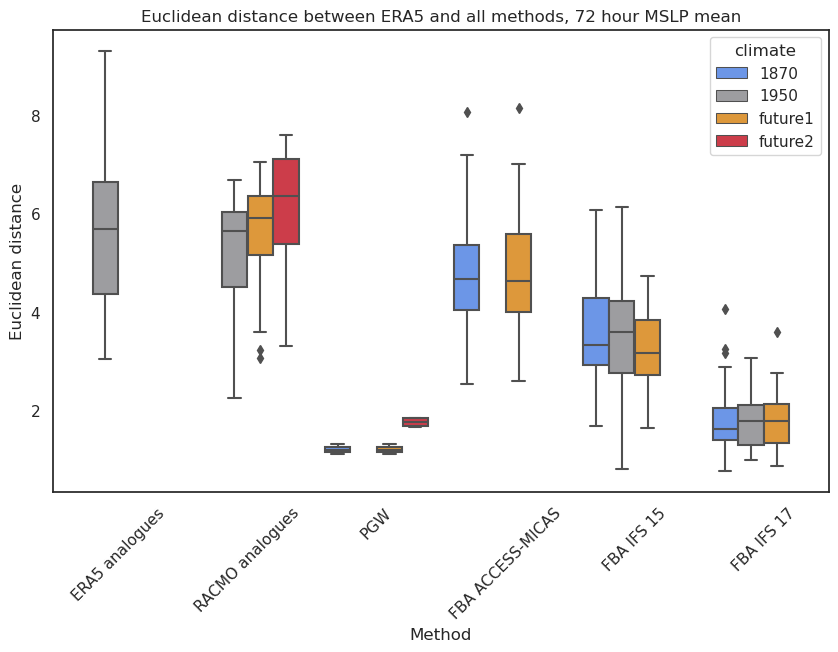

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='method', y='distance', hue='climate', data=plot_df, 
            palette=colors, 
            hue_order=['1870', '1950', 'future1', 'future2'],)
plt.ylabel('Euclidean distance')
plt.xlabel('Method')
plt.title("Euclidean distance between ERA5 and all methods, 72 hour MSLP mean")
plt.legend(title='climate')#, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

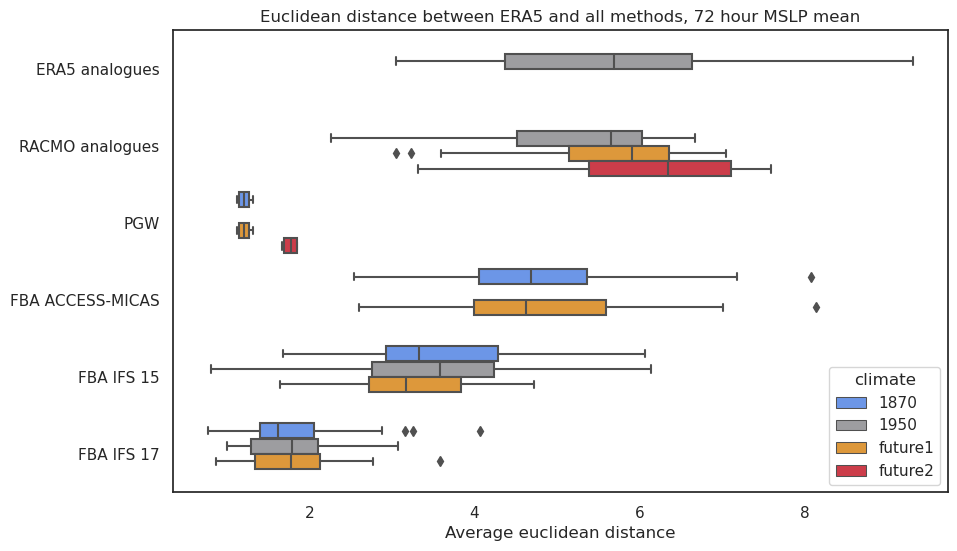

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='method', x='distance', hue='climate', data=plot_df, 
            palette=colors, 
            hue_order=['1870', '1950', 'future1', 'future2'])
plt.xlabel('Average euclidean distance')
plt.ylabel('')
plt.title("Euclidean distance between ERA5 and all methods, 72 hour MSLP mean")
plt.legend(title='climate', loc='lower right')
plt.yticks(rotation=0)  # optional, can rotate method labels if needed
# plt.show()

plt.savefig('figures/13_euclidean_distance_all_methods.png', bbox_inches='tight', dpi=600)